<a href="https://colab.research.google.com/github/AHernandez527/Tarea4_IA_Jimenez_Hernandez/blob/main/TareaProgramada4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tarea 4 - Inteligencia Artificial**

Adriana Vanessa Hernández Calderón   
Juan Pablo Jiménez Anderson

Para comenzar, se importan las librerías necesarias. Las que han sido usadas en tareas anteriores ya se conoce su aplicación, sin embargo se tienen scipy para lo que concierne a sistemas de control y pygad para algortmos evolutivos.

In [8]:
!pip install pygad
!pip install control slycot pygad
import numpy
import numpy as np
import random
import scipy
import control
import slycot
import os
import pygad
import pandas as pd
import matplotlib.pyplot as plt
from control.matlab import *

     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 339 kB 5.2 MB/s 
     |████████████████████████████████| 1.5 MB 40.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=a53e6929e1e136058104bdf03ec7cf990fb643ef01ef591c3c8b97499245830e
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417933 sha256=f954abc769b69d5effa97efd34ce202555fe9a8f254c25280083d45dcdc6744a
  Stored in directory: /root/.cache/pip/wheels/fa/b2/19/1e6568896fbabaf2a03d2fb6575211d281afcb9e00ce026cf6
Successfully built control slycot


El sistema fue resuelto a mano, encontrando así su función de ganancia y con esta la ubicación de los valores Ax, Bx,Cx, Dx,Fx,Hx,Kx.
Al comenzar, es establece una función que conformará cada uno de los genes, que se han establecido como valores enteros de una lista llamada "soluciones". 
A parit de esto se tendrá, gracias a las librerías de control, el cálculo de la función de tranferencia. 
Para determinar la continuidad o pausa de la mejor solución, se crean varias funciones. Una de estas en la funcion estabilidad, en base a esta funcion y a los valores obtenidos de error en la función de calidad, el algoritmo decidirá si seguir corriendo o si detenerse en la búsqueda de una mejor solución. 

Explicación de la función de calidad:  La función de calidad lo que busca es encontrar la diferencia de error en el tiempo en el que se encuentra el impulso máximo vs el tiempo en el que debería estar ese impulso máximo y la diferencia del valor máximo obtenido vs. el valor máximo que se debe obtener, es decir, qué tan lejos está el sobreimpulso de ser 1.2 * ult, siendo ult el valor en que se estabilizaría el sistema. 

Es así como la red debe seguir creando combinaciones hasta que se encuentre un valor de fitness suficientemente pequeño, puesto que la función de calidad está hecha para buscar un error, por lo que debe acercarse a 0, pero esto solo sucederá si el sistema es estable, caso contrario, sin importar el valor de la función de calidad, se seguirá ejecutando.

El segundo criterio de parada implementado fue haber corrido 250 generaciones sin éxito, en ese caso el algoritmo se detendrá y se deberían variar otros parámetros para encontrar la mejor solución.

In [31]:
def sistema_inicial(soluciones):
  A1=soluciones[0]
  A2=soluciones [1]
  A3=soluciones [2]
  B1=soluciones[3]
  B2=soluciones[4]
  B3=soluciones[5]
  C1=soluciones[6]
  C2=soluciones[7]
  C3=soluciones[8]
  D2=soluciones[9]
  F1=soluciones[10]
  F2=soluciones[11]
  K1=soluciones[12]
  K2=soluciones[13]
  K3=soluciones[14]

                                                                                # A continuación se escriben las ecuaciones de cada una de las partes del sistema
#### G1 ####
  G1n = A1
  G1d = [B1,B1*C1,0]
  G1=tf(G1n,G1d)

#### G2 ####
  G2n = [A2,0]
  G2d = [B2,0,B2*C2+D2]
  G2 = tf(G2n,G2d)

#### G3 ####
  G3n = [A3,A3*C3,0]
  G3d = B3
  G3 = tf (G3n,G3d)

#### H1 ####
  H1n = [K1*F1,K1]
  H1d = 1
  H1 = tf(H1n,H1d)

#### H2 ####
  H2n = [K2*F2,K2,0]
  H2d = 1
  H2 = tf(H2n,H2d)

#### H3 ####
  H3n = [K3,0]
  H3d = 1
  H3 = tf(H3n,H3d)

####   Ahora se representa la función de transferencia obtenida con Mason   ####

  M = (G1*G2*G3 + G1*G3*H1)/(1-G1*G2*G3-G1*H1*G3+G2*H2+H1*G3*H3+G2*G3*H3)
 
  return M

def estabilidad (sistema):                                                      #Esta es la forma de saber si el sistema es estable con los valores ingresados
  polos = pole(sistema)
  for i in polos:
    if (i.real == 0)|(i.real>0):
      return False
  return True                                                                   #En el caso de ser estable, devolverá un True

def back_gen (ga_instance):                                                     #Establece los puntos de parada 
                                                                           #Le entra el instance del algoritmo y sale cuando debe parar           
    global l_fitness
    print("Generacion = {generacion}".format(generacion=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Cambio     = {cambio}".format(cambio=ga_instance.best_solution()[1] - l_fitness))
    cambios.append(ga_instance.best_solution()[1] - l_fitness)
    l_fitness = ga_instance.best_solution()[1] 
    i=0
    
   
    if ga_instance.best_solution()[1] != 100: 
        if(ga_instance.best_solution()[1] < 0.1 and ga_instance.best_solution()[1] > -0.1) :
           print("CRITERIO DE PARADA ALCANZADO: se tiene un sistema estable y con calidad dentro del rango")
           print("Fitness de mejor mejor solución:")
           print(ga_instance.best_solution()[1])
           return "stop"
    if ga_instance.generations_completed == 500 :
       print("CRITERIO DE PARADA ALCANZADO: se corrieron 500 generaciones sin éxito")
       return "stop"

    



def valores1 (salida,tiempo): 
  salida_abs = np.abs(salida) 
  max_valor_sal = salida_abs.max()                                                                            #Funcion para obtener valores de salida y tiempo
  i = numpy.where(salida_abs == salida_abs.max())[0][0]
  tiempo_max = tiempo [i]
  ult_valor = salida[-1]
  return max_valor_sal, tiempo_max, ult_valor

                                                                                #Ahora se define una función de calidad del sistema
def f_calidad (solucion, iden_solucion):                                        #Esta es la función de calidad, que solo dará un valor de calidad
  M= sistema_inicial(solucion)                                                  #distinto de 100 en los casos en los que el sistema sea estable, por lo 
  if estabilidad(M) == True:                                                    #por lo que la red seguirá iterando las veces que sean necesarias hasta que 
    y_out, tiempo = step(M, T=200)                                              #se tenga un valor distinto del que representa la inestabilidad y ese 
    max, t_max, ult = valores1(y_out,tiempo)                                    #valor de calidad sea aceptable.
    error_temp = abs(1-t_max)
    valor_error = abs(max-(1.2*ult))/(1.2*ult)
    calidad = -(error_temp+valor_error)
  else: 
    calidad = 100  
  
  return calidad


def imprimir_sistema(sist):
  sal, t = step(sist, T=200)
  print("Valor Maximo: ")
  print(sal.max())
  i = numpy.where(sal == sal.max())[0][0]
  print("\nTiempo del maximo valor:")
  print(t[i])
  print("\nSobreimpulso:")
  print(abs(sal.max()-(sal[-1]*1.2)/(sal[-1]*1.2))*100)
  print("valor de estabilización")
  print (sal[-1])

                                                                                #Finalmente es necesario crear una funcion que genere la población inicial random
                                                                          
def people_generator (lista, dim):
  matriz = []
  for i in range (dim-1):
    lista2 =[]
    for k in range (len(lista)):
      x=random.randint(10,50)
      lista2.append(lista[k]+x)
    matriz.append(lista2)
  return matriz






A continuación se generará el primer arreglo poblacional. Para la primera generación, se crea una pobracion completamente aleatoria con la función people_generator y se conforma en un arreglo de numpy. 
Este arreglo esperará encontrar una solución con valores entre 10 y 50, sin embargo en función de encontrar los valores que calcen estos rangos pueden cambiarse muchas veces para buscar en rangos ampliados.

In [32]:
people1 = people_generator ([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],30)
arreglo1 = numpy.array(people1)
print(arreglo1)

[[48 26 45 29 42 48 30 19 39 47 30 15 27 12 24]
 [43 50 16 45 40 31 32 14 30 44 43 17 36 24 50]
 [49 16 38 37 26 30 12 45 36 26 10 32 25 40 12]
 [31 25 42 35 41 43 19 48 40 40 18 23 15 26 20]
 [38 37 33 18 24 42 12 35 28 23 30 50 44 23 20]
 [46 14 10 41 44 26 25 40 43 35 28 19 22 18 50]
 [29 48 20 42 25 38 27 35 31 10 38 34 29 33 19]
 [20 29 18 32 34 46 38 44 38 32 14 47 14 46 15]
 [33 49 31 36 35 49 38 33 50 35 14 44 41 46 32]
 [42 46 45 28 46 32 30 26 38 25 13 13 14 15 41]
 [21 18 17 41 27 42 48 13 17 12 39 23 42 25 48]
 [30 37 21 26 25 22 23 43 34 14 13 48 44 10 36]
 [37 37 19 20 36 18 20 40 44 17 42 35 17 38 14]
 [35 15 26 28 31 33 18 20 49 21 17 41 25 13 28]
 [10 27 41 50 45 50 25 46 22 48 11 38 36 25 40]
 [24 42 49 21 14 20 50 41 44 19 15 11 23 18 47]
 [26 30 48 29 38 11 36 14 34 44 32 31 49 39 42]
 [23 22 24 34 16 45 25 45 15 50 24 38 32 40 40]
 [48 22 29 20 10 29 46 37 28 22 31 44 32 38 39]
 [38 41 19 32 24 43 34 26 49 15 23 10 14 22 16]
 [44 42 31 43 47 49 24 13 23 13 11 22 33

Ahora es necesario trabajar con la red, para esto se estableceran un numero de generaciones, cantidad de soluciones que se tomarán en cuenta para la mejor solucion.
Además de esto se esogerán los parámetros para cruce, selección de padres y mutaciones.
En este caso tenemos el criterio de parada de las 250 generaciones (sin embargo se definió también en el back_gen para que se lance el mensaje de que el algoritmo ha sido detenido por este motivo).

Además se tienen otros parámetros importantes en la búsqueda de la solución: 
El numero de padres a reproducir será de 10 por generación, con 10 soluciones por cada población, en este caso no se necesitan parámetros como sol_per_pop, init_range_low, init_range_high, porque se tiene creada una población inical creada dentro de ciertos parámetros para el uso del algoritmo. 
Los tipos de cruce y selección de padres se estableción con el criterio tournament y la de mutación con el criterio random. 

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:486: UserWarning: The percentage of genes to mutate (mutation_percent_genes=5) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


Generacion = 1
Fitness    = 100
Cambio     = 100
Generacion = 2
Fitness    = 100
Cambio     = 0
Generacion = 3
Fitness    = 100
Cambio     = 0
Generacion = 4
Fitness    = 100
Cambio     = 0
Generacion = 5
Fitness    = 100
Cambio     = 0
Generacion = 6
Fitness    = 100
Cambio     = 0
Generacion = 7
Fitness    = 100
Cambio     = 0
Generacion = 8
Fitness    = 100
Cambio     = 0
Generacion = 9
Fitness    = 100
Cambio     = 0
Generacion = 10
Fitness    = 100
Cambio     = 0
Generacion = 11
Fitness    = 100
Cambio     = 0
Generacion = 12
Fitness    = 100
Cambio     = 0
Generacion = 13
Fitness    = 100
Cambio     = 0
Generacion = 14
Fitness    = 100
Cambio     = 0
Generacion = 15
Fitness    = 100
Cambio     = 0
Generacion = 16
Fitness    = 100
Cambio     = 0
Generacion = 17
Fitness    = 100
Cambio     = 0
Generacion = 18
Fitness    = 100
Cambio     = 0
Generacion = 19
Fitness    = 100
Cambio     = 0
Generacion = 20
Fitness    = 100
Cambio     = 0
Generacion = 21
Fitness    = 100
Cambio     = 0

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:3135: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


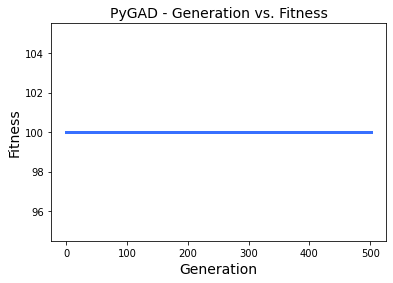

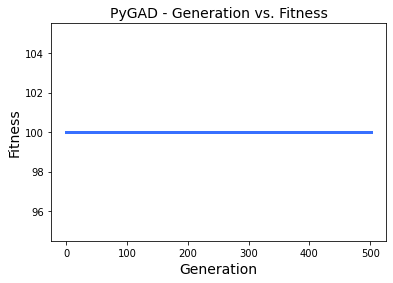

In [33]:
num_generacion = 500
num_reproducibles = 10

soluciones_pp = 10 #Cuantas soluciones habrán por poblacion.

init_range1 = 1
init_range2 = 100

seleccion_padres = "tournament"
n_padres_mant = 10

tipo_cruce = "scattered"

tipo_mutacion = "random"
genes_mutar = 5

l_fitness = 0
cambios = []

ga_instance = pygad.GA(num_generations = num_generacion,
                       num_parents_mating = num_reproducibles,
                       fitness_func = f_calidad, 
                       initial_population = people1,
                       #sol_per_pop = soluciones_pp,
                       #num_genes = 15, 
                       #init_range_low = init_range1, 
                       #init_range_high = init_range2,
                       gene_type=int,
                       parent_selection_type = seleccion_padres,
                       keep_parents = n_padres_mant, 
                       crossover_type = tipo_cruce,
                       mutation_type = tipo_mutacion, 
                       mutation_percent_genes = genes_mutar, 
                       on_generation = back_gen)
ga_instance.run()
ga_instance.plot_result()




A continuación se devuelven los reusltados del comportamiento del sistema, se puede ver además el diagrama de polos y ceros del sistema y la salida del mismo bajo el escenario del modelo ideal, es decir, con los valores hallados como los ideales.



Parameters of the best solution : [39 40 30  6 11 15 20 17 11 17 10 22  0 16 13]
Fitness value of the best solution = 100
Index of the best solution : 0


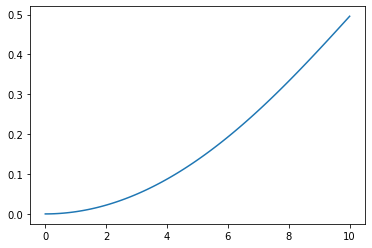

{'RiseTime': nan, 'SettlingTime': nan, 'SettlingMin': nan, 'SettlingMax': nan, 'Overshoot': nan, 'Undershoot': nan, 'Peak': inf, 'PeakTime': inf, 'SteadyStateValue': nan}


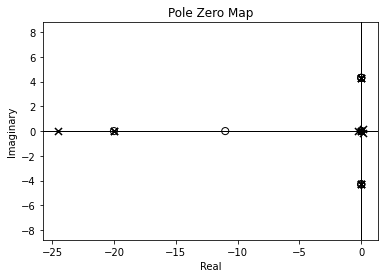

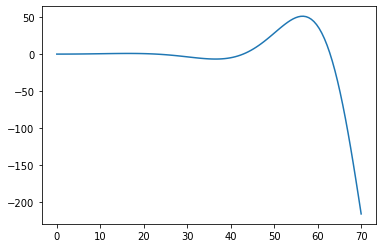

Valor Maximo: 
10238794.394218959

Tiempo del maximo valor:
176.50602409638554

Sobreimpulso:
1023879339.4218959
valor de estabilización
-59045577.1786837
(-24.510416633946903+0j)
(-20.002497490550567+0j)
(-20.000000000597552+0j)
(4.385127641004516e-07+4.306476783175928j)
(4.385127641004516e-07-4.306476783175928j)
(2.871281388483471e-05+4.306426292106466j)
(2.871281388483471e-05-4.306426292106466j)
(-2.9151326637666397e-05+4.306427050892561j)
(-2.9151326637666397e-05-4.306427050892561j)
(-0.2288235704175662+0j)
(0.10163807852548853+0.15696923233755253j)
(0.10163807852548853-0.15696923233755253j)
0j
0j

                                   8.409e+10 s^11 + 2.607e+12 s^10 + 2.318e+13 s^9 + 1.45e+14 s^8 + 1.116e+15 s^7 + 2.69e+15 s^6 + 1.963e+16 s^5 + 1.663e+16 s^4 + 1.18e+17 s^3
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1.6

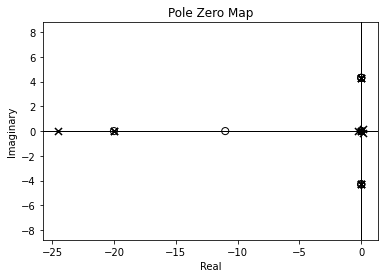

In [34]:
ideal_sol, sol_fit, sol_id = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=ideal_sol))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=sol_fit))
print("Index of the best solution : {solution_idx}".format(solution_idx=sol_id))

modelo_ideal = sistema_inicial(ideal_sol)


plt.figure(1)
yout, T = step(modelo_ideal, T=10)
plt.plot(T, yout)
plt.show(block=False)

pzmap(modelo_ideal)
S=stepinfo(modelo_ideal)
print(S)

plt.figure(2)
yout,T = step(modelo_ideal, T=70)
plt.plot(T,yout)
plt.show(block=False)

imprimir_sistema(modelo_ideal)

pzmap(modelo_ideal)
poles=pole(modelo_ideal)
for i in poles:
  print(i)
print(modelo_ideal)